# Feature Expansion: people going in and out of buildings

In this project, I will use a dataset of people going in and out of a building, and attempt to build a model that shows when the building is busiest. Of course, any human intuitively knows when an office building is busy, but I thought it would be interesting to see if it's possible to model such things with simple statistical methods. The dataset used for this project can be found [here](http://archive.ics.uci.edu/ml/datasets/CalIt2+Building+People+Counts). 

NOTE: I noticed about halfway through this project that there isn't really any point to this because the data is periodic - what are we even trying to predict? But it was quite fun, so it is what it is

In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('CalIt2.csv', header = None)
df.columns = ['flow', 'day', 'time', 'count']
df.head()

,flow,day,time,count
0,7,07/24/05,00:00:00,0
1,9,07/24/05,00:00:00,0
2,7,07/24/05,00:30:00,1
3,9,07/24/05,00:30:00,0
4,7,07/24/05,01:00:00,0


7 is out flow, and 9 is in flow. 

Let's visualize the data to get some sense of the structure. Net flow at each hour is a better indicator of activity in the building than the cumulative count - the data isn't perfect, as it has people slowly accumulating in the building.

We can see clearly that the net flow has a period of one week

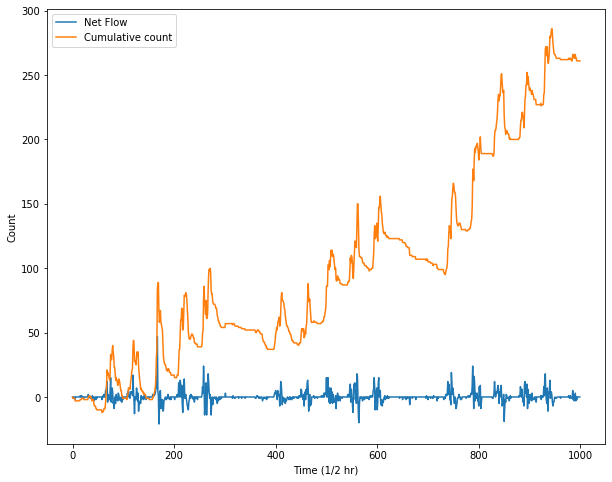

In [231]:
counts = df['count'].to_numpy()
a = np.empty(len(counts))

# Calculating net flow at each half-hour
flow = counts.reshape(counts.shape[0]//2, 2)
flow = flow[:,1] - flow[:,0]
plt.figure(figsize=(10,8))
plt.plot(flow[:1000])

# Cumulative sum
plt.plot(np.cumsum(flow)[:1000])
plt.legend(('Net Flow','Cumulative count'))
plt.xlabel('Time (1/2 hr)')
plt.ylabel('Count')
plt.show()

Since the data is periodic, we will use a Fourier basis:

$$
\phi_j(t)=\begin{cases}
    1 & \text{if } j = 0 \\
    \cos(\pi tj) & \text{odd } j \\
    \sin(\pi tj) & \text{even } j \\
\end{cases}
$$

We will construct design matrix $\Phi$ and targets $\mathbf{y}$ as:

$$
\Phi = \begin{bmatrix}
    \phi_0(t_1) & \phi_1(t_1) & \dots & \phi_K(t_1) \\
    \phi_0(t_2) & \phi_1(t_2) & \dots & \phi_K(t_2) \\
    \vdots      & \ddots      & \ddots &\vdots \\
    \phi_0(t_n) & \phi_1(t_n) & \dots & \phi_K(t_n) \\
\end{bmatrix}
$$

$$
\mathbf{y}=\begin{bmatrix}y_1, & y_2, &\dots, & y_n\end{bmatrix}^\top
$$

where $y_i$ is the net flow in the $i$-th time, and find the ordinary least squares solution $\mathbf{w}^\star=(\Phi^\top\Phi)^{-1}\Phi^{\top}\mathbf{y}$

I will fit on the first three weeks. We must make each day fit within an interval of length 2, because the basis functions are periodic on $[-1, 1]$. Also, we define a function to make the design matrix $\Phi$ based on the number of frequencies $K$.

In [232]:
# Prepare the data for regression, given the number of weeks
def prepare_data(data=flow, days=5):
    y = data[48:48*(1+days)] # Discarding first day, which is a sunday
    t = np.arange(-days, days, 2*days/y.shape[0])
    
    return (t, y)

# Prepare the design matrix Phi
def prepare_phi(t, K):
    t, y = prepare_data()
    js_odd  = np.arange(1, K, 2)
    js_even = np.arange(0, K, 2)
    phi_odd  = np.cos(np.pi * np.outer(t , js_odd))
    phi_even = np.sin(np.pi * np.outer(t, js_even))

    phi = np.empty((t.shape[0], K))
    phi[:,0::2] = phi_even
    phi[:,1::2] = phi_odd
    phi[:,0]    = np.ones(t.shape[0])

    return phi

Regression with $K=15$ 

In [233]:
t, y      = prepare_data()
phi       = prepare_phi(t, K=15)
phi_t     = phi.transpose()
phi_t_phi = np.dot(phi_t, phi)

w         = np.linalg.inv(phi_t_phi) @ phi_t @ y
w

array([ 0.28333333,  1.956699  , -1.22654413,  0.32861489,  0.26389413,
       -0.99288583, -0.73866342,  0.29963206, -0.534049  ,  0.03771546,
       -1.38921477, -0.14220719, -1.13333333,  0.40303085, -0.30408652])

Below are the results on days 5-7, 8-10 and 11-13. As seen from the plots, the model is... **not ideal**, but not as bad as I was expecting for weekdays. They are pretty bad for the weekends, because the period of was set at 1 day. Setting the period to 1 week, however, doesn't perform any better - it just has a single peak on Wednesdays, and huge valleys on the weekends.

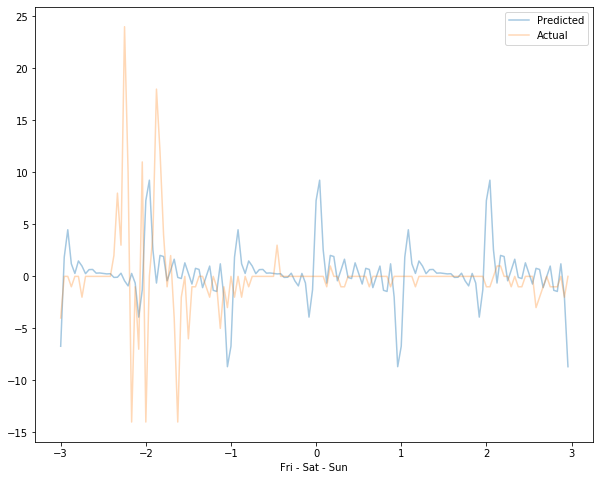

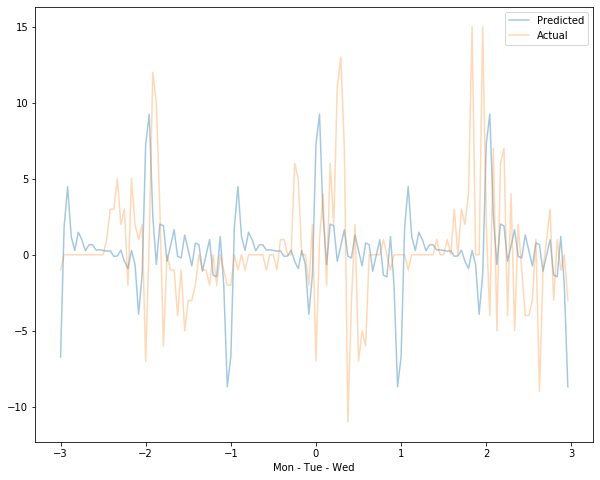

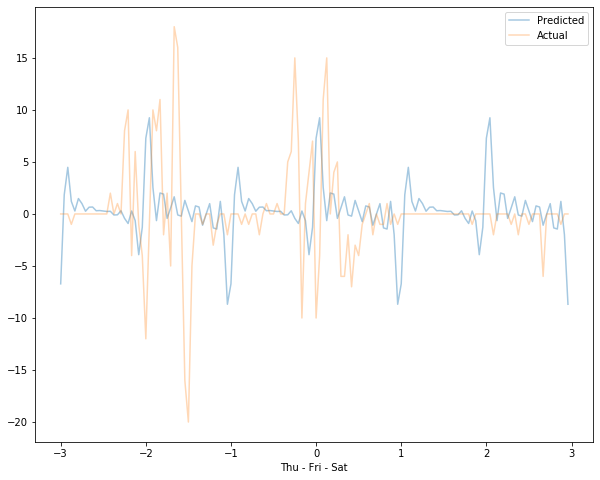

In [234]:
def make_curve(w,y,lab,days=3):    
    b     = w[0]
    w_cos = w[1::2]
    w_sin = w[2::2]
    j_cos = np.arange(1, w.shape[0], 2)
    j_sin = np.arange(0, w.shape[0], 2)
    
    x = np.arange(-days,days,2*days/y.shape[0])
    
    y_cos = np.cos(np.pi * np.outer(x , j_cos))
    y_sin = np.sin(np.pi * np.outer(x , j_sin))
    y_mat = np.empty((x.shape[0], w.shape[0]))
    y_mat[:,1::2] = y_cos
    y_mat[:,0::2] = y_sin
    y_mat[:,0]    = b * np.ones(x.shape[0])
    
    y_hat = np.sum(y_mat, axis=1)
    
    plt.figure(figsize=(10,8))
    plt.plot(x, y_hat, alpha=0.4)
    plt.plot(x, y, alpha=0.3)
    plt.xlabel(lab)
    plt.legend(('Predicted', 'Actual'))
    
t1 = flow[5*24*2:8*24*2]
t2 = flow[8*24*2:11*24*2]
t3 = flow[11*24*2:14*24*2]

make_curve(w, t1, 'Fri - Sat - Sun')
make_curve(w, t2, 'Mon - Tue - Wed')
make_curve(w, t3, 'Thu - Fri - Sat')